In [2]:
# Celula 1: Configurare Elastografie
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

ELASTO_IMG_DIR = r"C:\Users\Alex\Desktop\Proiect Lymphonod\Elastografie\img"
ELASTO_ANN_DIR = r"C:\Users\Alex\Desktop\Proiect Lymphonod\Elastografie\ann"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.50 
cfg.MODEL.DEVICE = "cpu"
cfg.MODEL.ROI_MASK_HEAD.POOLER_RESOLUTION = 28 

predictor = DefaultPredictor(cfg)
print("Model pregătit pentru Elastografie.")

Model pregătit pentru Elastografie.


In [3]:
# Celula 2: Algoritmi Elastografie (Translație Mască + Analiză Culori)

def translate_mask_to_color_region(image, mask):
    """
    Implementare Algoritm 4 (PDF):
    Detectează unde e B-mode (Alb-Negru) și unde e Elastografia (Color).
    Mută masca de pe B-mode pe Color.
    """
    h, w = image.shape[:2]
    mid_x = w // 2
    
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    left_half = hsv[:, :mid_x, 1] # Canalul Saturație
    right_half = hsv[:, mid_x:, 1]
    
    mean_sat_left = np.mean(left_half)
    mean_sat_right = np.mean(right_half)
    
    M = cv2.moments(mask)
    if M["m00"] == 0: return mask, False # Eronat
    cX = int(M["m10"] / M["m00"])
    
    mask_is_on_left = cX < mid_x
    color_is_on_left = mean_sat_left > mean_sat_right + 10 # +10 prag de siguranță
    
    translation = 0
    
    if mask_is_on_left and not color_is_on_left:
        translation = mid_x 
        print(" -> Translație Mască: Stânga >>> Dreapta")
        
    elif not mask_is_on_left and color_is_on_left:
        translation = -mid_x
        print(" -> Translație Mască: Dreapta <<< Stânga")
    
    else:
        print(" -> Nu este necesară translația (Overlay sau detectat direct).")
        return mask, False

    M_trans = np.float32([[1, 0, translation], [0, 1, 0]])
    translated_mask = cv2.warpAffine(mask, M_trans, (w, h))
    
    return translated_mask, True

def analyze_elastography_colors(image, mask):
    """
    Calculează procentele de Albastru (Hard), Verde (Intermediar), Roșu (Soft).
    Intervale HSV conform PDF .
    """
    masked_img = cv2.bitwise_and(image, image, mask=mask)
    hsv = cv2.cvtColor(masked_img, cv2.COLOR_BGR2HSV)
    
    lower_red1 = np.array([0, 50, 50]); upper_red1 = np.array([39, 255, 255])
    lower_red2 = np.array([136, 50, 50]); upper_red2 = np.array([180, 255, 255])
    
    lower_green = np.array([40, 50, 50]); upper_green = np.array([79, 255, 255])
    
    lower_blue = np.array([80, 50, 50]); upper_blue = np.array([135, 255, 255])
    
    mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask_red = cv2.bitwise_or(mask_red1, mask_red2)
    
    mask_green = cv2.inRange(hsv, lower_green, upper_green)
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
    
    mask_red = cv2.bitwise_and(mask_red, mask_red, mask=mask)
    mask_green = cv2.bitwise_and(mask_green, mask_green, mask=mask)
    mask_blue = cv2.bitwise_and(mask_blue, mask_blue, mask=mask)
    
    total_pixels = cv2.countNonZero(mask)
    if total_pixels == 0: return 0,0,0
    
    p_red = (cv2.countNonZero(mask_red) / total_pixels) * 100
    p_green = (cv2.countNonZero(mask_green) / total_pixels) * 100
    p_blue = (cv2.countNonZero(mask_blue) / total_pixels) * 100
    
    return p_blue, p_green, p_red

def smooth_mask(mask_raw):
    mask_blurred = cv2.GaussianBlur(mask_raw, (19, 19), 0)
    _, mask_smooth = cv2.threshold(mask_blurred, 127, 255, cv2.THRESH_BINARY)
    return mask_smooth

Analizez Elastografie: ADENOCC_PAROT_OP_META_GGL_20111214152930_00001.bmp
 -> Translație Mască: Dreapta <<< Stânga

=== RAPORT ELASTOGRAFIE ===
* Blue (Hard):  72.5%
* Green (Inter):26.1%
* Red (Soft):   1.4%
* Hard Tissue:  98.6% (>40% = Malign)
* Shape Ratio:  0.49
* RESULT:       MALIGN (Hard/Rigid)


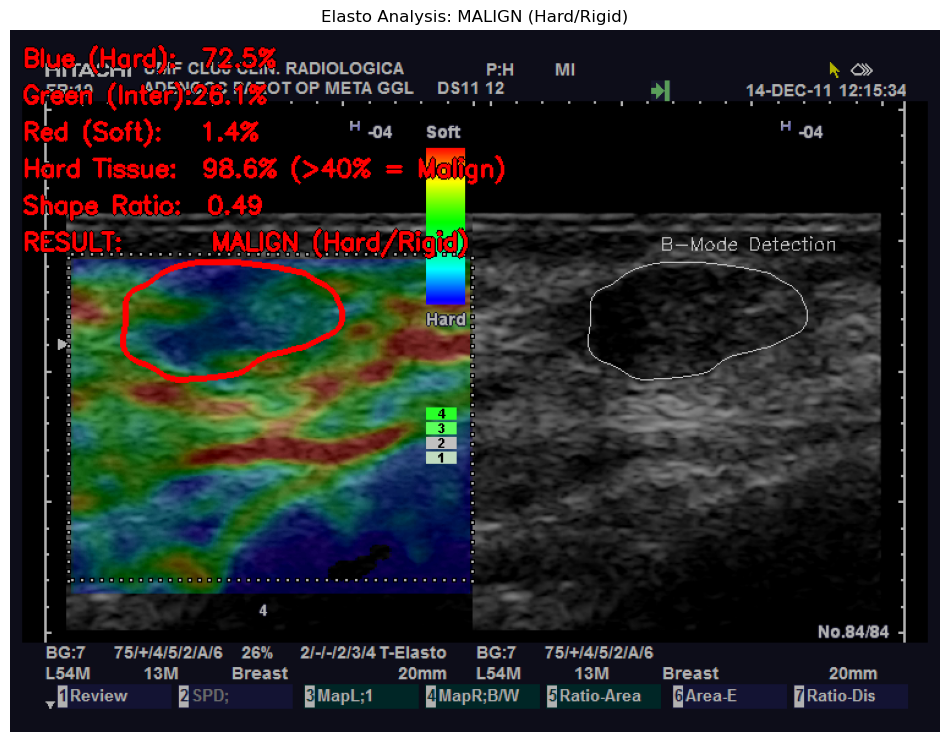

In [16]:
# Celula 3: Analiză Elastografie Completă (Translation + Diagnostic)

def get_files(d):
    return [os.path.join(d, f) for f in os.listdir(d) if f.lower().endswith(('.jpg','.png','.bmp'))]

files = get_files(ELASTO_IMG_DIR)

if not files:
    print("Nu sunt imagini în folderul img_elasto!")
else:
    img_path = random.choice(files)
    im = cv2.imread(img_path)
    img_display = im.copy()
    
    print(f"Analizez Elastografie: {os.path.basename(img_path)}")
    
    outputs = predictor(im)
    instances = outputs["instances"].to("cpu")
    
    if len(instances) > 0:
        best = instances[0]
        score_ai = best.scores.numpy()[0]
        mask_raw = best.pred_masks[0].numpy().astype('uint8') * 255
        mask_smooth = smooth_mask(mask_raw)
        
        mask_color_region, was_translated = translate_mask_to_color_region(im, mask_smooth)
        
        blue_pct, green_pct, red_pct = analyze_elastography_colors(im, mask_color_region)
        
        contours_orig, _ = cv2.findContours(mask_smooth, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnt_orig = contours_orig[0]
        
        contours_color, _ = cv2.findContours(mask_color_region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnt_color = contours_color[0] if len(contours_color) > 0 else cnt_orig
        
        if len(cnt_orig) >= 5:
            ellipse = cv2.fitEllipse(cnt_orig)
            (center, axes, angle) = ellipse
            MA, ma = axes
            shape_ratio = min(MA, ma) / max(MA, ma)
            
            hard_tissue_pct = blue_pct + green_pct
            
            score_malign = 0
            reasons = []
            
            if hard_tissue_pct > 40.0:
                score_malign += 2 
                reasons.append(f"Rigid ({hard_tissue_pct:.0f}%)")
            
            if shape_ratio > 0.6:
                score_malign += 1
                reasons.append("Sferic")
                
            if score_malign >= 2:
                diag_text = "MALIGN (Hard/Rigid)"
                color = (0, 0, 255) 
            elif score_malign == 1:
                diag_text = "SUSPECT (Mixt)"
                color = (0, 165, 255) 
            else:
                diag_text = "BENIGN (Soft)"
                color = (0, 255, 0) 
                        
            cv2.drawContours(img_display, [cnt_color], -1, color, 3)
            
            if was_translated:
                cv2.drawContours(img_display, [cnt_orig], -1, (200, 200, 200), 1)
                cv2.putText(img_display, "B-Mode Detection", (cnt_orig[0][0][0], cnt_orig[0][0][1]-10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200,200,200), 1)
            infos = [
                f"Blue (Hard):  {blue_pct:.1f}%",
                f"Green (Inter):{green_pct:.1f}%",
                f"Red (Soft):   {red_pct:.1f}%",
                f"Hard Tissue:  {hard_tissue_pct:.1f}% (>40% = Malign)",
                f"Shape Ratio:  {shape_ratio:.2f}",
                f"RESULT:       {diag_text}"
            ]
            
            y0, dy = 30, 30
            font = cv2.FONT_HERSHEY_SIMPLEX
            print("\n=== RAPORT ELASTOGRAFIE ===")
            for i, line in enumerate(infos):
                print(f"* {line}")
                y = y0 + i*dy
                cv2.putText(img_display, line, (10, y), font, 0.65, (0,0,0), 4)
                cv2.putText(img_display, line, (10, y), font, 0.65, color, 2)
            
            plt.figure(figsize=(12, 10))
            plt.imshow(img_display[:, :, ::-1])
            plt.title(f"Elasto Analysis: {diag_text}")
            plt.axis('off')
            plt.show()
            
    else:
        print("Modelul nu a detectat nodulul.")
        plt.imshow(im[:, :, ::-1])
        plt.show()